This project was based on the article [Encoding Time Series as Images](https://medium.com/analytics-vidhya/encoding-time-series-as-images-b043becbdbf3)

In [798]:
import csv
import math
import matplotlib.pyplot as plt
import numpy as np
import random
from pylab import rcParams

In [951]:
# config settings
config = {
    "offset": 2000,
    "size": 512,
    "volatility": (0., 0.03),
    "y_target": 5.,
    "y_min": -5.,
    "y_max": 37.,
    "y_thresholds": (2., 8.),
    "y_range": (y_min, y_max),
    "default_penalty": 1.,
    "cold_penalty": 10.,
    "warm_penalty": 2.
}

config['max_penalty'] = max(config['cold_penalty'], config['warm_penalty']) + config['default_penalty']

# Set the default figure size to be
rcParams['figure.figsize'] = (15, 15)

In [940]:
def read_csv_file (filename):
    csv_reader = csv.reader(open(filename, 'r'))
    rows = list(csv_reader)[1:]
    return np.array(rows)

def tabulate (x, y, fn):
    return np.vectorize(fn)(*np.meshgrid(x, y, sparse=True))

def cos_sum (a, b):
    return (math.cos(a + b))

def normalize (x, x_range, t_range=(-1., 1.)):
    return (t_range[1] - t_range[0]) * (x - x_range[0]) / (x_range[1] - x_range[0]) + t_range[0]

def process_data (x, y, config):
    # normalize y
    y_norm = normalize(y, config['y_range'])
    
    # normalize x
    x_max = np.amax(x)
    x_min = np.amin(x)
    x_range = (x_min, x_max)
    x_norm = normalize(x, x_range, [0., 1.])
    
    # polarize time series
    gaf, phi, r = get_gaf(x_norm, y_norm)
    
    # create colors from phi angles
    colors = 2 * phi
    
    # calculate penalty score
    penalty = get_penalty(x_norm, y, config)
    
    return (x_norm, y_norm, gaf, phi, r, colors, penalty)

def get_gaf (x_norm, y_norm):
    # polarize time series
    phi = np.arccos(y_norm)
    r = x_norm
    
    # calculate gaf
    gaf = tabulate(phi, phi, cos_sum)
    
    return (gaf, phi, r)

def get_penalty (x, y, config):
    y_t = config['y_target']
    y_r0 = config['y_range'][0]
    y_r1 = config['y_range'][1]
    y_th0 = config['y_thresholds'][0]
    y_th1 = config['y_thresholds'][1]
    y_abs = np.where(y > y_t, (y - y_t) / (y_r1 - y_t), (y_t - y) / (y_t - y_r0))
    y_cold = np.where(y_th0 and y < y_th0, (y_th0 - y) / (y_th0 - y_r0), 0) * config['cold_penalty']
    y_warm = np.where(y_th1 and y > y_th1, (y - y_th1) / (y_r1 - y_th1), 0) * config['warm_penalty']
    return (np.trapz(y_abs, x) + np.trapz(y_cold, x) + np.trapz(y_warm, x)) / config['max_penalty']

def plot_line (x, y, colors, config):
    y_t = config['y_target']
    y_th0 = config['y_thresholds'][0]
    y_th1 = config['y_thresholds'][1]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_ylim(config['y_range'] or (np.amin(y), np.amax(y)))
    ax.plot([0., 1.], [y_t, y_t], dashes=(2, 3), c='grey')
    ax.plot([0., 1.], [y_th0, y_th0], dashes=(4, 4), c='r')
    ax.plot([0., 1.], [y_th1, y_th1], dashes=(4, 4), c='r')
    ax.plot(x, y)
#     ax.scatter(x, y, s=1, c=colors, cmap='hsv', vmin=-math.pi, vmax=math.pi)

def plot_polar (phi, r, colors, config):
    y_r = config['y_range']
    y_th0 = config['y_thresholds'][0]
    y_th1 = config['y_thresholds'][1]
    y_target_norm = normalize(config['y_target'], y_r)
    y_threshold_min_norm = normalize(y_th0, y_r)
    y_threshold_max_norm = normalize(y_th1, y_r)
    fig = plt.figure()
    ax = fig.add_subplot(111, polar=True)
    ax.set_thetamin(0)
    ax.set_thetamax(180)
    ax.set_xticks(np.pi / 180. * np.linspace(180, 0, 4, endpoint=False))
    ax.plot(np.pi - np.arccos([y_target_norm, y_target_norm]), [0, 1], dashes=(2, 3), c='grey')
    ax.plot(np.pi - np.arccos([y_threshold_min_norm, y_threshold_min_norm]), [0, 1], dashes=(4, 4), c='r')
    ax.plot(np.pi - np.arccos([y_threshold_max_norm, y_threshold_max_norm]), [0, 1], dashes=(4, 4), c='r')
    ax.plot(np.pi - phi, r)
#     ax.scatter(np.pi - phi, r, s=1, c=colors, cmap='hsv', vmin=-math.pi, vmax=math.pi)

def plot_gaf (gaf):
    # Gramian Angular Field
    # plt.imshow(gaf)
    plt.matshow(gaf)
    
def plot_all (data, config):
    print('penalty: %0.2f%%' % (data['penalty'] * 100.))
    plot_line(data['x_norm'], data['y'], data['colors'], config)
    plot_polar(data['phi'], data['r'], data['colors'], config)
    plot_gaf(data['gaf'])

In [941]:
def generate_graph (config):
    y_max = config['y_max']
    y_min = config['y_min']
    y_r = y_max - y_min
    y_r = config['y_max'] - config['y_min']
    x = np.sort(np.random.uniform(low=0., high=1., size=(config['size'] - 2,)))
    x = np.insert(x, 0, 0.)
    x = np.append(x, 1.)
    y = []
    for index, xi in enumerate(x):
        volatility = random.uniform(*config['volatility'])
        rnd = random.uniform(-1., 1.)
        y_prev = y_target if index == 0 else y0
        y0 = y_prev + y_r * volatility * rnd
        y0 = min(y0, y_max)
        y0 = max(y0, y_min)
        y.append(y0)
    y = np.array(y)
    return (x, y, label)

def generate_data (config, count=10):
    data = []
    for i in range(count):
        x, y, label = generate_graph(config)
        x_norm, y_norm, gaf, phi, r, colors, penalty = process_data(x, y, config)
        data.append({
            "x": x,
            "x_norm": x_norm,
            "y": y,
            "y_norm": y_norm,
            "gaf": gaf,
            "phi": phi,
            "r": r,
            "colors": colors,
            "penalty": penalty
        })
    return data

In [984]:
data = generate_data({ **config, "volatility": (0.00, 0.05) })
for i, x in enumerate(data):
    print('index %d: penalty: %0.6f%%' % (i, x['penalty'] * 100))

index 0: penalty: 67.220398%
index 1: penalty: 20.054569%
index 2: penalty: 6.941555%
index 3: penalty: 12.257887%
index 4: penalty: 50.732708%
index 5: penalty: 19.677510%
index 6: penalty: 15.020544%
index 7: penalty: 49.165378%
index 8: penalty: 2.208039%
index 9: penalty: 50.569533%


penalty: 2.21%


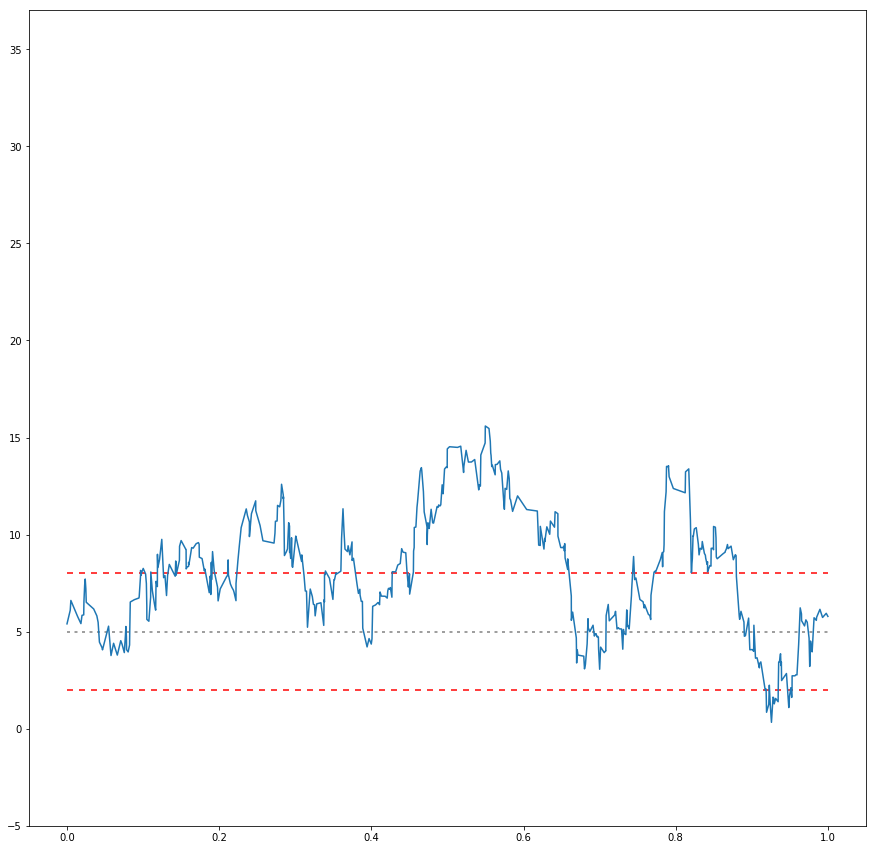

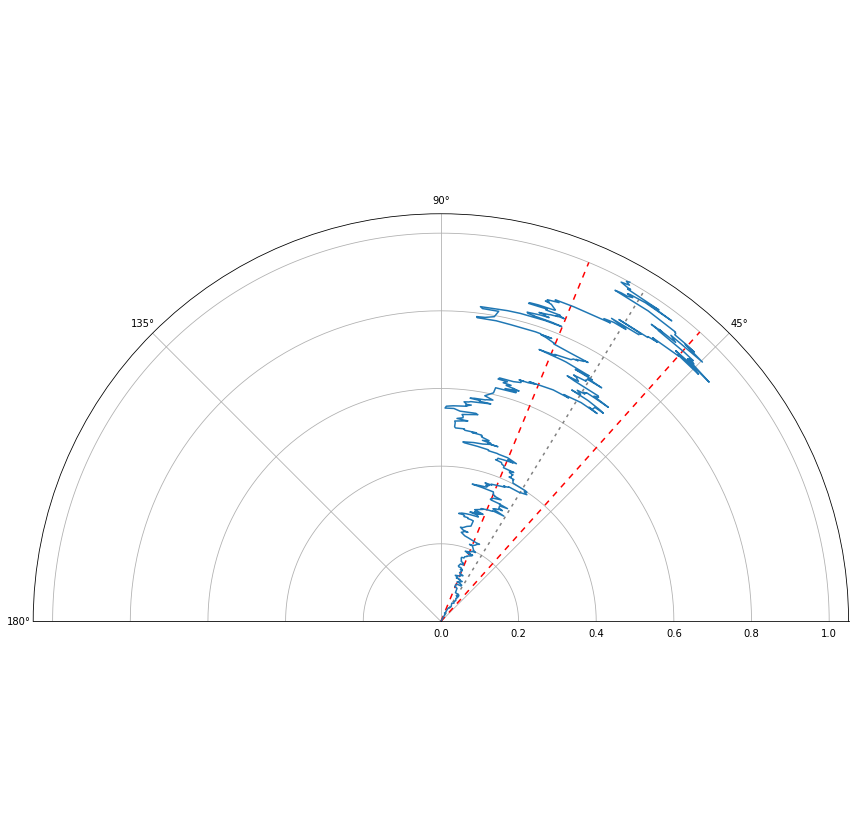

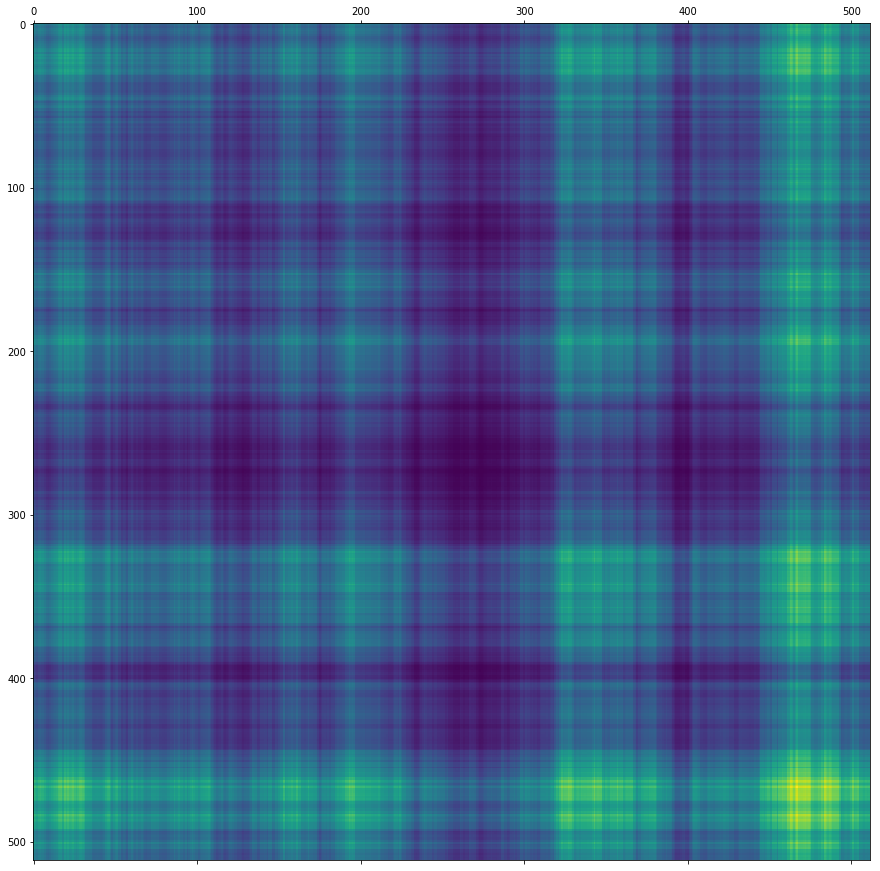

In [986]:
plot_all(data[8], config)

In [960]:
# read CSV file
data = read_csv_file('1f000250.csv')

# process and normalize data
x = data[:,0].astype(int)[offset:offset+size]
y = data[:,1].astype(float)[offset:offset+size]
# y = np.ones(len(x)) * y_min
# y = (np.arange(len(x)) / len(x)) * (y_max - y_min) + y_min

# process data x and y
x_norm, y_norm, gaf, phi, r, colors, penalty = process_data(x, y, config)
pena

0.19801402836653192

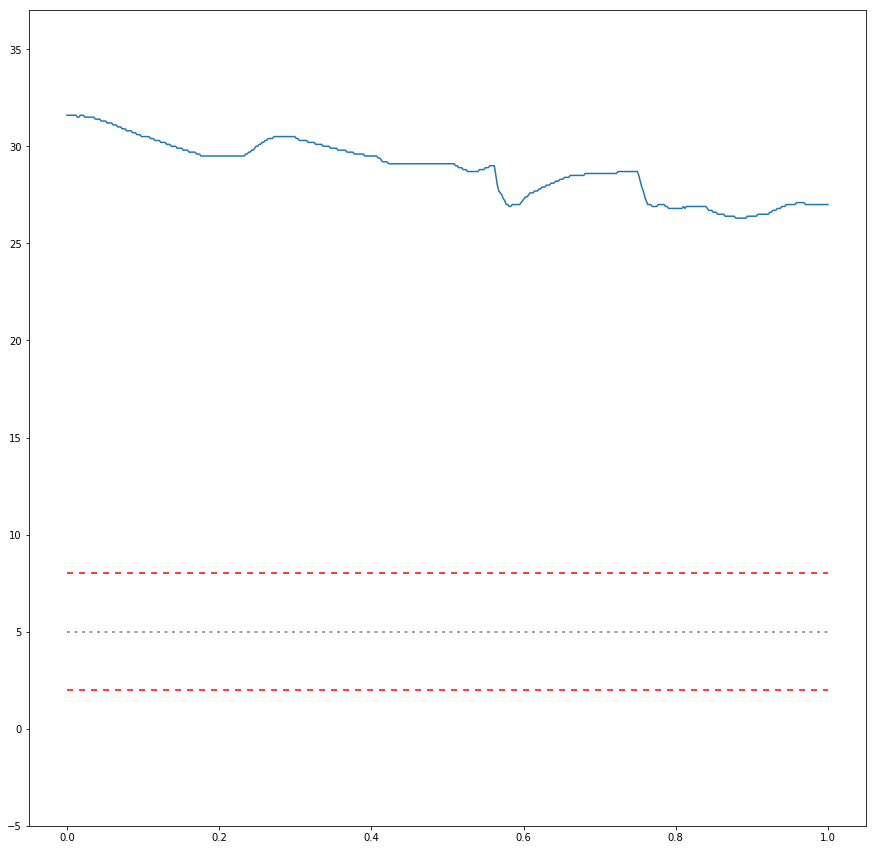

In [961]:
plot_all(data[1], config)

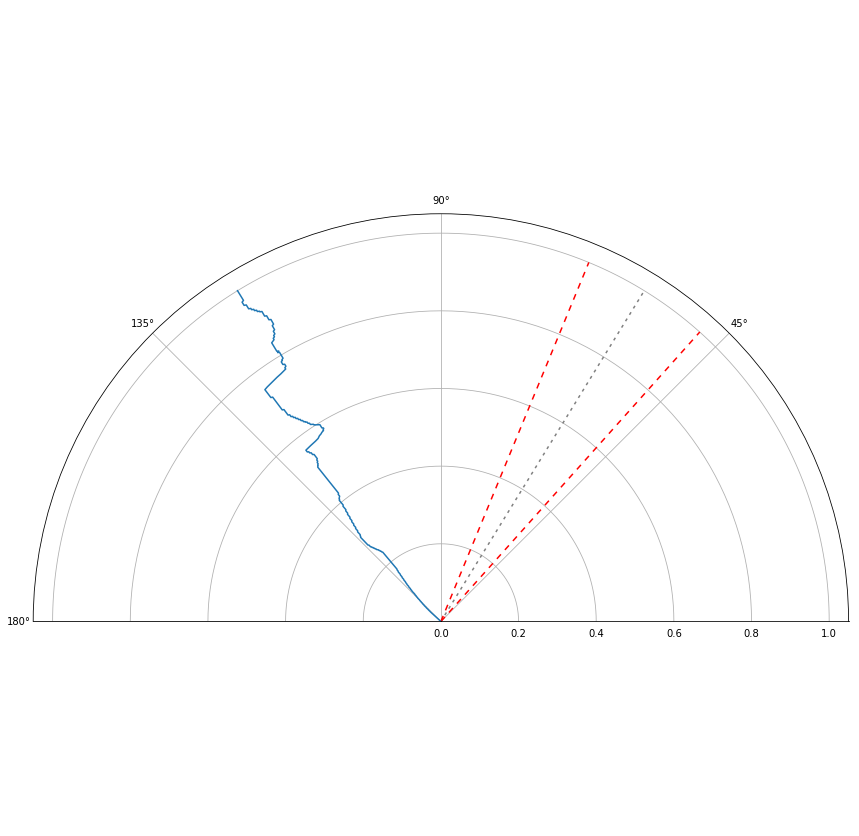

In [962]:
plot_polar(phi, r, colors, config)

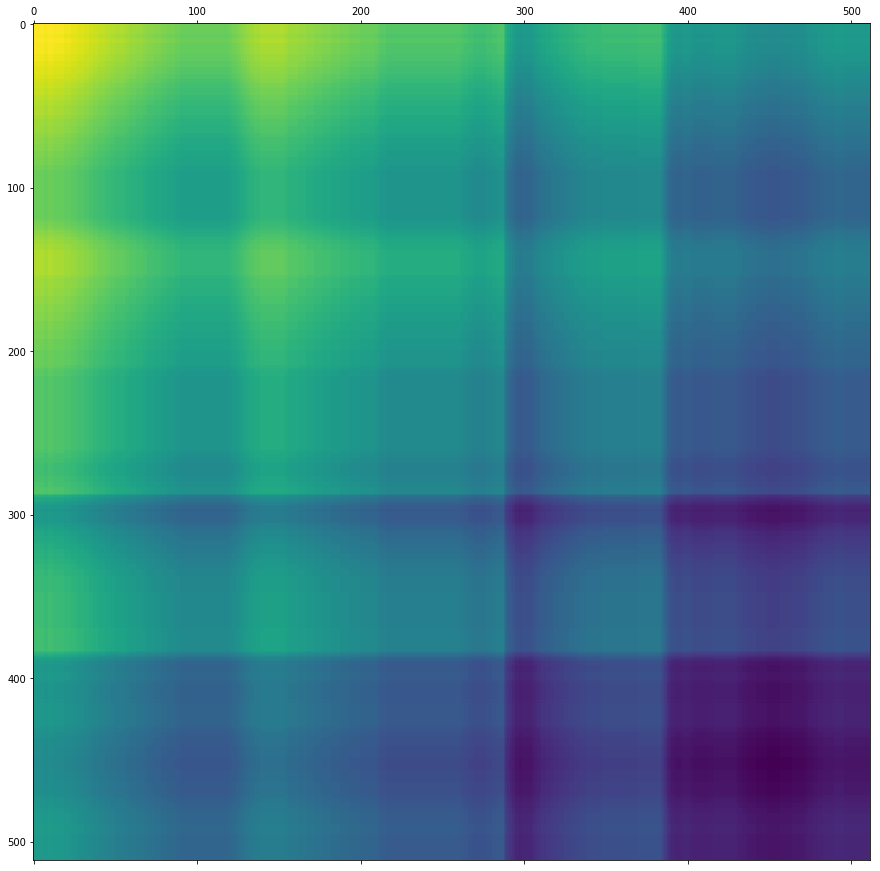

In [963]:
plot_gaf(gaf)